In [1]:
#Libraries imports
import torch
import edward
from edward.models import Categorical
import pandas as pd
import time
import numpy as np
import random
import tensorflow as tf
import matplotlib as mpl
mpl.use('agg')
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
#Load test data and necessary data for prediction inspection
#/home/yannis/Desktop/runs24s/
with open('/tmp/bayesian_compression_24sensorsbnnTest/bnnTest_point_PDF.pt','rb') as f:
         probs = torch.load(f)
with open('/tmp/bayesian_compression_24sensorsbnnTest/test_data_24sensors_teacherLabels.pt','rb') as f:
      test_ = torch.load(f)



test_data = test_ 
N = len(test_data)


In [3]:
#Student bayesian model
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pyro
from pyro.distributions import Normal

p = 24
hidden_nodes = 7
output_nodes = 4


class BNNModel(nn.Module):
    def __init__(self, p, hidden_nodes,output_nodes):
        super(BNNModel, self).__init__()
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.fc1 = nn.Linear(p, self.hidden_nodes)
        self.fc4 = nn.Linear(self.hidden_nodes, self.output_nodes)

    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(self.fc4(x))
        x = F.softmax(x,dim=-1)
        return x

    
#Load trained model
PATH = "./bnn_test_model.pt"
bnn_model = BNNModel(p,hidden_nodes,output_nodes)
bnn_model.load_state_dict(torch.load(PATH))
CUDA_ = False 
softplus = nn.Softplus()

def guide(data):
    if CUDA_:
        w_mu1 = Variable(torch.randn(hidden_nodes, p).cuda(), requires_grad=True)
        w_log_sig1 = Variable((-3.0 * torch.ones(hidden_nodes, p) + 0.05 * torch.randn(hidden_nodes, p)).cuda(), requires_grad=True)
        b_mu1 = Variable(torch.randn(1, hidden_nodes).cuda(), requires_grad=True)
        b_log_sig1 = Variable((-3.0 * torch.ones(1, hidden_nodes) + 0.05 * torch.randn(1, hidden_nodes)).cuda(), requires_grad=True)
        
        w_mu4 = Variable(torch.randn(output_nodes, hidden_nodes).cuda(), requires_grad=True)
        w_log_sig4 = Variable((-3.0 * torch.ones(output_nodes, hidden_nodes) + 0.05 * torch.randn(output_nodes, hidden_nodes)).cuda(), requires_grad=True)
        b_mu4 = Variable(torch.randn(1, output_nodes).cuda(), requires_grad=True)
        b_log_sig4 = Variable((-3.0 * torch.ones(1, output_nodes) + 0.05 * torch.randn(1, output_nodes)).cuda(), requires_grad=True)

    else:
        w_mu1 = Variable(torch.randn(hidden_nodes, p), requires_grad=True)
        w_log_sig1 = Variable((-3.0 * torch.ones(hidden_nodes, p) + 0.05 * torch.randn(hidden_nodes, p)), requires_grad=True)
        b_mu1 = Variable(torch.randn(1, hidden_nodes), requires_grad=True)
        b_log_sig1 = Variable((-3.0 * torch.ones(1, hidden_nodes) + 0.05 * torch.randn(1, hidden_nodes)), requires_grad=True)
        
        w_mu4 = Variable(torch.randn(output_nodes, hidden_nodes), requires_grad=True)
        w_log_sig4 = Variable((-3.0 * torch.ones(output_nodes, hidden_nodes) + 0.05 * torch.randn(output_nodes, hidden_nodes)), requires_grad=True)
        b_mu4 = Variable(torch.randn(1, output_nodes), requires_grad=True)
        b_log_sig4 = Variable((-3.0 * torch.ones(1, output_nodes) + 0.05 * torch.randn(1, output_nodes)), requires_grad=True)


    # register learnable params in the param store
    mw_param1 = pyro.param("guide_mean_weight1", w_mu1)
    sw_param1 = softplus(pyro.param("guide_log_sigma_weight1", w_log_sig1))
    mb_param1 = pyro.param("guide_mean_bias1", b_mu1)
    sb_param1 = softplus(pyro.param("guide_log_sigma_bias1", b_log_sig1))
    # gaussian guide distributions for w and b
    w_dist1 = Normal(mw_param1, sw_param1)
    b_dist1 = Normal(mb_param1, sb_param1)
    
    # register learnable params in the param store
    mw_param4 = pyro.param("guide_mean_weight4", w_mu4)
    sw_param4 = softplus(pyro.param("guide_log_sigma_weight4", w_log_sig4))
    mb_param4 = pyro.param("guide_mean_bias4", b_mu4)
    sb_param4 = softplus(pyro.param("guide_log_sigma_bias4", b_log_sig4))
    # gaussian guide distributions for w and b
    w_dist4 = Normal(mw_param4, sw_param4)
    b_dist4 = Normal(mb_param4, sb_param4)
    

    #dists = {'fc1.weight': w_dist1, 'fc1.bias': b_dist1, 'fc2.weight': w_dist2, 'fc2.bias': b_dist2, 'fc3.weight': w_dist3, 'fc3.bias': b_dist3, 'fc4.weight': w_dist4, 'fc4.bias': b_dist4}
    dists = {'fc1.weight': w_dist1, 'fc1.bias': b_dist1, 'fc4.weight': w_dist4, 'fc4.bias': b_dist4}
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", bnn_model, dists)
    # sample a regressor
    return lifted_module()


In [8]:
#Inspect posterior predictive distribution

y_post = []
n_samples = 10000


t0 = time.time()

for i in xrange(N):
    #print("Forming the posterior predictive distribution for test data point", i+1, "/", len(test_data), "...")
    y_post.append(Categorical(probs = probs[i]))
print("Took altogether", np.int(time.time() - t0), "secs.")

t0 = time.time()                                                                                                                                                                                                                                                                                                                                                                                                                                                            
print("Sampling the posterior predictive distribution for", len(test_data), "test data points...")

#Posterior samples contain n_samples samples from each posterior predictive distribution, shape = n_samples x N
psnodes = np.zeros((n_samples,N))
with tf.Session().as_default():
    for i in xrange(N):
        psnodes[:,i] = y_post[i].sample(n_samples).eval()
    posteriorsamples = pd.DataFrame(psnodes)
"""    
#Sample models and get predictions
y_preds = []
for i in range(n_samples):
    sampled_reg_model = guide(None)
    y_preds.append(sampled_reg_model(Variable(torch.Tensor(test_data[:,0:p]))).data.numpy())
 
ypred = np.asarray(y_preds)
print(ypred.shape)
psnodes = np.zeros((n_samples,N))
for i in xrange(len(test_data)):
    psnodes[:,i] = (np.argmax(ypred[:,i,:],axis=1))   
    #print(psnodes[:,i])
    #print(ypred[:,i,:])

posteriorsamples = pd.DataFrame(psnodes)
"""
#print(posteriorsamples)
print("Took", np.int(time.time() - t0), "secs.")

(100000, 327, 4)
('Took', 323, 'secs.')


In [9]:
#Inspect prediction statistics

#Predictions are the mean over the #n_samples predicted values for each test data point
#predictions = posteriorsamples.mean()

mostCommonVote=[]
for i in xrange(N):
    votes, values = np.unique(psnodes[:,i], return_counts=True)
    if np.all(values<=1):
        mostCommonVote.append(psnodes[0,i])
    else:
        mostCommonVote.append( votes[np.argmax(values)] )
predictions = mostCommonVote

predictions_low = posteriorsamples.quantile(0.01)
predictions_high = posteriorsamples.quantile(0.99)

results = pd.DataFrame()
results['Bayesian_prediction'] = predictions    
results['Bayesian_prediction_low'] = predictions_low
results['Bayesian_prediction_high'] = predictions_high

#Results contain the accuracy of the predictions on the test data points
print("Accuracy on test data for Bayesian neural network:")
print(len(np.where(results['Bayesian_prediction']==np.argmax(test_data[:,24:28],axis=1))[0])/float(len(test_data[:,2]))*100)
#results


Accuracy on test data for Bayesian neural network:
31.1926605505


In [ ]:
#Visualise one (random) prediction and associated uncertainty
names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
bins=[0,1,2,3,4]
#test_sample_number = np.random.choice(range(len(test_data)))
for i in xrange(len(test_data)):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    test_sample_number = i
    
    _, _, histogram = plt.hist(posteriorsamples[test_sample_number].values, bins=bins, density=True, align='left',rwidth=0.3)
    plt.xlabel("Predicted class")
    plt.ylabel("PDF (counts/n_samples x binwidth)")
    plt.axvline(results.loc[test_sample_number, 'Bayesian_prediction'], color='g', linewidth=4, label="Bayesian NN")
    plt.axvline(np.argmax(test_data[test_sample_number,2:6]), color='k', linewidth=4, label="Ground truth")
    plt.legend()
    plt.title("Results for test data point " + str(test_sample_number))
    ax.set_xticks(bins)
    ax.set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
    plt.show()
    time.sleep(0.5)

In [ ]:
for i in xrange(len(test_data)):
    fig = plt.figure(1, figsize=(15, 5))
    test_sample_number = i
    #Boxplot of predictions
    #ax = fig.add_subplot(111)
    #bp = ax.boxplot(psnodes[:,i])
    #plt.xlabel("Test sample")
    #plt.ylabel("Prediction")
    #Violin plot of predictions
    ax = fig.add_subplot(111) #(121)
    vp = ax.violinplot(psnodes[:,i], showmeans=False, showmedians=True, showextrema=False)
    
    ax.set_yticks(bins)
    ax.set_yticklabels(names)
    plt.title("Results for test data point " + str(test_sample_number))
    plt.xlabel("Test sample")
    plt.ylabel("Bayesian prediction")
    plt.show()
    time.sleep(0.5)

In [ ]:
#Stem plot of predictions vs features
"""
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)
markerline, stemlines, baseline = plt.stem(test_data[0:100,0], predictions[0:100], '-.')
plt.xlabel("Sensor front")
plt.ylabel("Prediction")
"""
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(211)
markerline, stemlines, baseline = plt.stem(test_data[0:100,1], predictions[0:100], '-.')
plt.xlabel("Sensor left")
ymin, ymax = plt.ylim()
plt.show()

In [ ]:
#Accuracy vs compression ratio

#Data for 24-sensor input
teacher_accuracy = [86.69, 80.18, 86.88, 85.41, 77.06,  85.14, 87.89, 85.87 , 76.79,  88.26]
#Compression ratios: total number of teacher neurons over total number of student neurons (best performing for same arch networks)
#compress_ratios = [float(34876.0/56.0), float(34876.0/112.0), float(34876.0/168.0), float(34876.0/196.0), float(34876.0/252.0), float(34876.0/560.0), float(34876.0/1400.0), float(34876.0/2800.0), float(34876.0/5600.0), float(34876.0/28000.0)]
compress_ratios = [56, 112, 168, 196, 252, 560, 1400, 2800, 5600, 28000]
student_accuracies = [71.55, 74.00, 74.31, 72.17, 66.67, 67.58, 64.53, 62.08, 64.22, 58.72 ]


fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(compress_ratios,student_accuracies, color='green', marker='o', linestyle='dashed',linewidth=2, 
         markersize=12)
plt.axhline(np.median(teacher_accuracy), color='r', linewidth=1, label="Median teacher performance")
plt.ylabel("Accuracy of student network")
#plt.xlabel("Compress ratio (teacher_neurons/student_neurons)")
plt.xlabel("Number of student neurons")
plt.plot(34876,np.median(teacher_accuracy),color='r', markersize=12)

Confusion matrix, without normalization
[[  2  37  13   0]
 [ 29   6  27   0]
 [  1  57  32   0]
 [  2  13 108   0]]


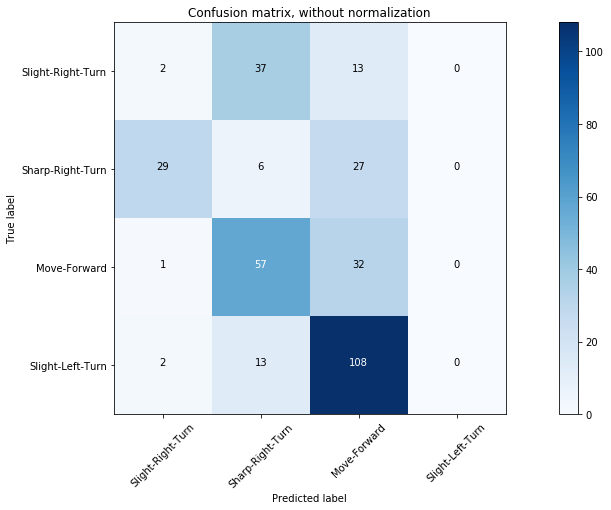

In [12]:
#Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
  
cnf_matrix = confusion_matrix(np.argmax(test_data[:,-5:-1],axis=1), predictions)
plt.figure(1, figsize=(15, 7))
plot_confusion_matrix(cnf_matrix, classes=names,normalize=False,title='Confusion matrix, without normalization')